# Central Line: Probe Orientation Classifier

General pipeline:
1. Take in an image and preprocess it
2. Use unet to generate segmented image
3. Use transfer learning to define pretrained network
4. convolve image, softmax activation to get 3 output classes.


---
 
## Define user parameters

In [58]:
#Paths
input_dir = r"C:\repos\aigt\DeepLearnLive\Datasets\US_Vessel_Segmentations"
# unet_path = r"C:\Users\cbarr\OneDrive - Queen's University\Grad School\Courses\CISC 881\Project\Data\Logs\Output_CentralLineUNET_1\Central_Line_UNet_model_2020-11-28_10-33-36"
output_dir = r"C:\Users\cbarr\OneDrive - Queen's University\Grad School\Courses\CISC 881\Project\Paper"
# output_dir = r"C:\Users\cbarr\Desktop\classifier_output"

unet_fold_0 = r"C:\Users\cbarr\OneDrive - Queen's University\Grad School\Courses\CISC 881\Project\IMNO Outputs\Central_Line_UNet_fold_0_2020-12-04_18-38-12"
unet_fold_1 = r"C:\Users\cbarr\OneDrive - Queen's University\Grad School\Courses\CISC 881\Project\IMNO Outputs\Central_Line_UNet_fold_1_2020-12-04_18-56-38"
unet_fold_2 = r"C:\Users\cbarr\OneDrive - Queen's University\Grad School\Courses\CISC 881\Project\IMNO Outputs\Central_Line_UNet_fold_2_2020-12-04_19-06-04"
unet_fold_3 = r"C:\Users\cbarr\OneDrive - Queen's University\Grad School\Courses\CISC 881\Project\IMNO Outputs\Central_Line_UNet_fold_3_2020-12-04_19-14-59"

#Learning parameters
image_size = 128

test_idx = [15,16,17,18,19]

## Imports

In [2]:
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import datetime
from ipywidgets import IntProgress
from IPython.display import display, HTML
import numpy as np
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Input, GlobalAveragePooling2D, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import Sequence


## Preprocess data

In [4]:
sequence_names = [name for name in os.listdir(input_dir)]

def process_us(us_img, output_size):
    resized_img = cv2.resize(us_img, (output_size, output_size)).astype(np.float16)
    return resized_img / resized_img.max()

def accumulate_and_process(all_img_paths, processing_fxn, output_size, f): 
    data = np.array([], dtype=np.float64).reshape(output_size, output_size, 0)
    for idx, img_path in enumerate(all_img_paths):
        f.value = idx
        img = cv2.imread(os.path.abspath(img_path), 0)
        processed_img = processing_fxn(img, output_size)
        data = np.dstack((data, processed_img))
    return data

us_data_by_seq = []
labels_by_seq = []

for seq in sequence_names:
    
    print("current sequence name: " + seq)
    
    us_paths = list(Path(input_dir + "\\" + seq).glob(seq+"_[0-9][0-9][0-9][0-9][0-9].png"))
    
    f_us = IntProgress(min=0, max=len(us_paths))                    
    print(seq + " Ultrasound processing progress: ")
    display(f_us)
                         
    #Accumulate and process images
    us_data = accumulate_and_process(us_paths, process_us, image_size, f_us)
    
    #Read in the labels for this data
    labels_path = os.path.join((input_dir + "\\" + seq), (seq+"_Labels.csv"))
    labels_df = pd.read_csv(labels_path)
    
    #Save the numpy files
    output_us_path = os.path.join(output_dir, seq +"_ultrasound" )
    output_seg_path = os.path.join(output_dir, seq+"_label" )
    np.save(output_us_path, us_data)
    np.save(output_seg_path, labels_df)
    
    #Add additional axis and rearrange
#     us_data = us_data[...,np.newaxis]
#     us_data = us_data.transpose(2,1,0,3)
    
    #Verify that the length of labels is equal to the length of us_data
#     print("Number of us images: {} | Number of labels: {}".format(us_data.shape[0], labels_df.shape[0]))
    
    #Append the us data to the list
#     us_data_by_seq.append(us_data)
#     labels_by_seq.append(labels_df)

# #Aggregate all the collected data
# all_us_data = np.concatenate(us_data_by_seq, axis=0)
# all_labels = pd.concat(labels_by_seq)

# #Extract only the labels of the orientations
# orientation_labels = np.array(all_labels.Probe_Orientation)

# #Specify the output file name
# output_path = os.path.join(output_dir, "all_data.npz")

# #Save the data to the file
# np.savez(output_path, us_data = all_us_data, labels = orientation_labels)

current sequence name: MS01-20200210-132740
MS01-20200210-132740 Ultrasound processing progress: 


IntProgress(value=0, max=1749)

current sequence name: MS01-20200210-133541
MS01-20200210-133541 Ultrasound processing progress: 


IntProgress(value=0, max=1123)

current sequence name: MS01-20200210-134522
MS01-20200210-134522 Ultrasound processing progress: 


IntProgress(value=0, max=1088)

current sequence name: MS01-20200210-135109
MS01-20200210-135109 Ultrasound processing progress: 


IntProgress(value=0, max=1005)

current sequence name: MS01-20200210-135709
MS01-20200210-135709 Ultrasound processing progress: 


IntProgress(value=0, max=830)

current sequence name: MS02-20200210-152131
MS02-20200210-152131 Ultrasound processing progress: 


IntProgress(value=0, max=1319)

current sequence name: MS02-20200210-152827
MS02-20200210-152827 Ultrasound processing progress: 


IntProgress(value=0, max=1059)

current sequence name: MS02-20200210-153709
MS02-20200210-153709 Ultrasound processing progress: 


IntProgress(value=0, max=979)

current sequence name: MS02-20200210-154411
MS02-20200210-154411 Ultrasound processing progress: 


IntProgress(value=0, max=833)

current sequence name: MS02-20200210-160404
MS02-20200210-160404 Ultrasound processing progress: 


IntProgress(value=0, max=1389)

current sequence name: MS03-20200213-152826
MS03-20200213-152826 Ultrasound processing progress: 


IntProgress(value=0, max=1218)

current sequence name: MS03-20200213-153647
MS03-20200213-153647 Ultrasound processing progress: 


IntProgress(value=0, max=1214)

current sequence name: MS03-20200213-154347
MS03-20200213-154347 Ultrasound processing progress: 


IntProgress(value=0, max=1076)

current sequence name: MS03-20200213-155250
MS03-20200213-155250 Ultrasound processing progress: 


IntProgress(value=0, max=1256)

current sequence name: MS03-20200213-155823
MS03-20200213-155823 Ultrasound processing progress: 


IntProgress(value=0, max=663)

current sequence name: MS04-20200213-173406
MS04-20200213-173406 Ultrasound processing progress: 


IntProgress(value=0, max=1663)

current sequence name: MS04-20200213-174259
MS04-20200213-174259 Ultrasound processing progress: 


IntProgress(value=0, max=1188)

current sequence name: MS04-20200213-175619
MS04-20200213-175619 Ultrasound processing progress: 


IntProgress(value=0, max=1070)

current sequence name: MS04-20200213-180237
MS04-20200213-180237 Ultrasound processing progress: 


IntProgress(value=0, max=1120)

current sequence name: MS04-20200213-180907
MS04-20200213-180907 Ultrasound processing progress: 


IntProgress(value=0, max=1070)

ValueError: need at least one array to concatenate

## Read in data and seperate into training / validation / testing sets

In [3]:
#Read the US image and segmentations paths into lists
data_input_dir = r"C:\Users\cbarr\OneDrive - Queen's University\Grad School\Courses\CISC 881\Project\Data\ClassifierDataNp"
label_files = list(sorted(Path(data_input_dir).glob("*_label.npy")))
us_files = list(sorted(Path(data_input_dir).glob("*_ultrasound.npy")))

#Go through all file paths in both arrays and append to list
us_data_by_seq = []
label_by_seq = []
for i in range(len(us_files)):
    
    #Load the current files as 3D numpy arrays
    us_np = np.load(os.path.abspath(us_files[i]))
    label_np = np.load(os.path.abspath(label_files[i]), allow_pickle=True)
    
    #Normalize and add channel dimension
    us_np = us_np[...,np.newaxis] / 255
    
    #Append to the collector lists.
    us_data_by_seq.append(us_np.transpose(2,1,0,3))
    label_by_seq.append(label_np[:,4])
    
    
#Verify that the total number of segmentation images matches the total number of us images.
for idx in range(len(us_data_by_seq)):
    if len(label_by_seq[idx][0]) != len(us_data_by_seq[idx][0]):
        print("Data Problem: Dataset {} has {} ultrasounds and {} labels". format(
            idx, us_data_by_seq[idx].shape[0], len(label_by_seq[idx])))

Data Problem: Dataset 0 has 1749 ultrasounds and 1749 labels
Data Problem: Dataset 1 has 1123 ultrasounds and 1123 labels
Data Problem: Dataset 2 has 1088 ultrasounds and 1088 labels
Data Problem: Dataset 3 has 1005 ultrasounds and 1005 labels
Data Problem: Dataset 4 has 830 ultrasounds and 830 labels
Data Problem: Dataset 5 has 1319 ultrasounds and 1319 labels
Data Problem: Dataset 6 has 1059 ultrasounds and 1059 labels
Data Problem: Dataset 7 has 979 ultrasounds and 979 labels
Data Problem: Dataset 8 has 833 ultrasounds and 833 labels
Data Problem: Dataset 9 has 1389 ultrasounds and 1389 labels
Data Problem: Dataset 10 has 1218 ultrasounds and 1218 labels
Data Problem: Dataset 11 has 1214 ultrasounds and 1214 labels
Data Problem: Dataset 12 has 1076 ultrasounds and 1076 labels
Data Problem: Dataset 13 has 1256 ultrasounds and 1256 labels
Data Problem: Dataset 14 has 663 ultrasounds and 663 labels
Data Problem: Dataset 15 has 1663 ultrasounds and 1663 labels
Data Problem: Dataset 16 h

In [33]:
len(labels_np)

1749

In [39]:
#Create lists of indices for training and validation sets
trainAndVal_idx = list(range(len(us_data_by_seq)))
trainAndVal_idx = [x for x in trainAndVal_idx if x not in test_idx] #Remove IDs

#Extract and concatenate the labels for train / test / val
y_trainAndVal = np.concatenate(np.take(label_by_seq, trainAndVal_idx), axis=0)
y_test = np.concatenate(np.take(label_by_seq, test_idx), axis=0)

#Extract and concatenate the ultrasound images for train / test / val
X_trainAndVal = np.concatenate(np.take(us_data_by_seq, trainAndVal_idx), axis=0)
X_test = np.concatenate(np.take(us_data_by_seq, test_idx), axis=0)

#Extract training and validation sets from trainAndVal using 80/20 split
X_train, X_val, y_train, y_val = train_test_split(X_trainAndVal, y_trainAndVal, test_size=0.2, random_state=2)

C:\repos\dlenv\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [40]:
#get rid of any nans
y_train[pd.isnull(y_train)] = 'Undefined'
y_val[pd.isnull(y_val)] = 'Undefined'
y_test[pd.isnull(y_test)] = 'Undefined'

#onehot encode the labels
encoder = OneHotEncoder(handle_unknown='ignore')
y_train = encoder.fit_transform(y_train.reshape(-1,1)).toarray()
y_val = encoder.fit_transform(y_val.reshape(-1,1)).toarray()
y_test = encoder.fit_transform(y_test.reshape(-1,1)).toarray()

# y_onehot = y_onehot.toarray()

In [7]:
# encoder = OneHotEncoder(handle_unknown='ignore')
# y_onehot = pd.DataFrame(encoder.fit_transform())

# X_trainANDval, X_test, y_trainANDval, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=1)
# X_train, X_val, y_train, y_val = train_test_split(X_trainANDval, y_trainANDval, test_size=0.25, random_state=1)

In [41]:
print("Trained on {} images, validated on {} images, tested on {} images.".format(X_train.shape[0],
                                                                                 X_val.shape[0],
                                                                                 X_test.shape[0]))

Trained on 13440 images, validated on 3361 images, tested on 6111 images.


In [22]:
import collections
collections.Counter(y)

NameError: name 'y' is not defined

## Define network architecture

### Arch 1 - simple cnn

In [42]:
#Read in the unet model
unet_model =  tf.keras.models.load_model(unet_fold_3, compile=False)
unet_model.trainable = False

def freezeWeights(model,num_customLayers):
    numUntrainableLayers = len(model.layers) - num_customLayers
    for layer in model.layers[:numUntrainableLayers]:
        layer.trainable=False
    for layer in model.layers[numUntrainableLayers:]:
        layer.trainable=True
    return model

#Define the architecture of the classifier
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(128,128,3))

base_model.trainable = False

In [43]:
input_layer = Input(shape=(image_size, image_size, 1))

unet_layer = unet_model(inputs=input_layer)

cov = Conv2D(8, (3, 3), activation='relu')(unet_layer)  
cov = Conv2D(8, (3, 3), activation='relu')(cov)  
pl = MaxPool2D((3, 3))(cov)   

# cov = Conv2D(32, (3, 3), activation='relu')(pl)  
# cov = Conv2D(32, (3, 3), activation='relu')(cov)  
# pl = MaxPool2D((3, 3))(cov)

# cov = Conv2D(64, (3, 3), activation='relu')(pl)  
# pl = MaxPool2D((2, 2))(cov)

fl = Flatten()(pl)

# resize_layer = Conv2D(3,1,padding='same')(unet_layer)

# mobilenet_layer = base_model(resize_layer)

# avg_pool_layer = GlobalAveragePooling2D()(mobilenet_layer)

d1 = Dense(64, activation='relu')(fl)

d2 = Dense(3, activation='softmax')(d1)

model = tf.keras.Model(
    inputs=input_layer,
    outputs=d2,
)

# for layer in model.layers[:-2]:
#     layer.trainable = False

model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


In [44]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
model (Model)                (None, 128, 128, 2)       304902    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 126, 126, 8)       152       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 124, 124, 8)       584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 41, 41, 8)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 13448)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8607

In [45]:
history = model.fit(x=X_train, 
                    y=y_train, 
                    validation_data=(X_val, y_val),
                    batch_size=300,
                    epochs=10,
                    verbose=1,
                    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)
    ])

Train on 13440 samples, validate on 3361 samples
Epoch 1/10
13440/13440 [==============================] - 98s 7ms/sample - loss: 0.7000 - accuracy: 0.7852 - val_loss: 0.2015 - val_accuracy: 0.9390
Epoch 2/10
13440/13440 [==============================] - 98s 7ms/sample - loss: 0.1765 - accuracy: 0.9469 - val_loss: 0.1561 - val_accuracy: 0.9554
Epoch 3/10
13440/13440 [==============================] - 96s 7ms/sample - loss: 0.1560 - accuracy: 0.9556 - val_loss: 0.1464 - val_accuracy: 0.9634
Epoch 4/10
13440/13440 [==============================] - 97s 7ms/sample - loss: 0.1479 - accuracy: 0.9616 - val_loss: 0.1495 - val_accuracy: 0.9592
Epoch 5/10
13440/13440 [==============================] - 96s 7ms/sample - loss: 0.1407 - accuracy: 0.9636 - val_loss: 0.1340 - val_accuracy: 0.9661
Epoch 6/10
13440/13440 [==============================] - 96s 7ms/sample - loss: 0.1366 - accuracy: 0.9638 - val_loss: 0.1348 - val_accuracy: 0.9661
Epoch 7/10
13440/13440 [==============================] -

In [46]:
results = model.evaluate(X_test, y_test, batch_size=300)

6111/6111 [==============================] - 19s 3ms/sample - loss: 0.3852 - accuracy: 0.8683


In [50]:
test_pred = model.predict(X_test)
test_pred_labels = tf.argmax(test_pred, axis=1)
test_actual_labels = tf.argmax(y_test, axis=1)
num_classes = 3

In [51]:
confusion_matrix = tf.math.confusion_matrix(test_actual_labels, test_pred_labels , 3)

confusion_matrix

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[2046,   90,  143],
       [  47,  225,   12],
       [  64,  449, 3035]])>

In [52]:
from sklearn.metrics import classification_report, accuracy_score

target_names = ['Cross-section', 'Long-axis', 'Undefined']

print(classification_report(test_actual_labels, test_pred_labels, target_names=target_names))

               precision    recall  f1-score   support

Cross-section       0.95      0.90      0.92      2279
    Long-axis       0.29      0.79      0.43       284
    Undefined       0.95      0.86      0.90      3548

     accuracy                           0.87      6111
    macro avg       0.73      0.85      0.75      6111
 weighted avg       0.92      0.87      0.89      6111



In [73]:
output_dir = r"C:\Users\cbarr\OneDrive - Queen's University\Grad School\Courses\CISC 881\Project\Data\Logs\CrossVal_Classifier"
notebook_name = "CentralLine_ProbeOrientationClassifier"
save_timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# Archive trained model with unique filename based on notebook name and timestamp
model_file_name = notebook_name + "_fold_4_" + save_timestamp
model_fullname = os.path.join(output_dir, model_file_name)
model.save(model_fullname)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: C:\Users\cbarr\OneDrive - Queen's University\Grad School\Courses\CISC 881\Project\Data\Logs\CrossVal_Classifier\CentralLine_ProbeOrientationClassifier_fold_4_2020-12-01_19-48-48\assets


AttributeError: 'Model' object has no attribute 'loss'

## Figures / Results

In [37]:
acc = np.array([0.9422,0.9285,0.9484,0.8671])
prec = np.array([0.90,0.92,0.95,0.92])
rec = np.array([0.84,0.93,0.95,0.87])

print("Accuracy: {} std {}".format(acc.mean(), acc.std()))
print("Precision: {} std {}".format(prec.mean(), prec.std()))
print("Recall: {} std {}".format(rec.mean(), rec.std()))

Accuracy: 0.9215500000000001 std 0.032250775184482015
Precision: 0.9225 std 0.0178535710713571
Recall: 0.8975 std 0.04437059837324713


In [55]:
overall_confusion = np.array([[2421+1224+1932+2035, 114+95+6+100, 80+19+27+144],
                              [33+216+194+41, 283+106+290+228, 88+42+35+15],
                              [11+6+5+60, 9+21+13+452, 2756+3849+2925+3036]])


In [56]:
import matplotlib.pyplot as plt

SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 17

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Normalized confusion matrix
[[0.92863243 0.03842869 0.03293888]
 [0.30808402 0.57733927 0.1145767 ]
 [0.00623906 0.03766263 0.9560983 ]]


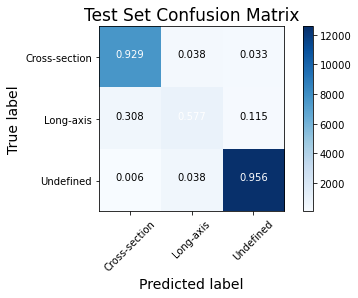

In [63]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues,
                        save_fig = False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 3),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if save_fig:
        file_path = os.path.join(output_dir, "Confusion_Matrix.pdf")
        plt.savefig(file_path, bbox_inches = "tight")
        
    
# plot_confusion_matrix(confusion_matrix.numpy(), 
#                       ["Cross-section", "Long-axis", "Undefined"], 
#                       normalize=True,
#                      title='Test Set Confusion Matrix',
#                      save_fig=True)

plot_confusion_matrix(overall_confusion, 
                      ["Cross-section", "Long-axis", "Undefined"], 
                      normalize=True,
                     title='Test Set Confusion Matrix',
                     save_fig=True)

## Define network architecture

### Arch 1 - with mobile net

In [64]:
#Read in the unet model
unet_model =  tf.keras.models.load_model(unet_path, compile=False)
unet_model.trainable = False

def freezeWeights(model,num_customLayers):
    numUntrainableLayers = len(model.layers) - num_customLayers
    for layer in model.layers[:numUntrainableLayers]:
        layer.trainable=False
    for layer in model.layers[numUntrainableLayers:]:
        layer.trainable=True
    return model

#Define the architecture of the classifier
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(128,128,3))

base_model.trainable = False

In [73]:
input_layer = Input(shape=(image_size, image_size, 1))

unet_layer = unet_model(inputs=input_layer)

cov = Conv2D(8, (3, 3), activation='relu')(unet_layer)  
cov = Conv2D(8, (3, 3), activation='relu')(cov)  
pl = MaxPool2D((3, 3))(cov)   

cov = Conv2D(16, (3, 3), activation='relu')(pl)  
cov = Conv2D(16, (3, 3), activation='relu')(cov)  
pl = MaxPool2D((3, 3))(cov)

# cov = Conv2D(64, (3, 3), activation='relu')(pl)  
# pl = MaxPool2D((2, 2))(cov)

fl = Flatten()(pl)

# resize_layer = Conv2D(3,1,padding='same')(unet_layer)

# mobilenet_layer = base_model(resize_layer)

# avg_pool_layer = GlobalAveragePooling2D()(mobilenet_layer)

d1 = Dense(32, activation='relu')(fl)

d2 = Dense(3, activation='softmax')(d1)

model = tf.keras.Model(
    inputs=input_layer,
    outputs=d2,
)

# for layer in model.layers[:-2]:
#     layer.trainable = False

model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


In [74]:
history = model.fit(x=X_train, 
                    y=y_train, 
                    validation_data=(X_val, y_val),
                    batch_size=300,
                    epochs=10,
                    verbose=1)

Train on 6873 samples, validate on 2291 samples
Epoch 1/10
6873/6873 [==============================] - 59s 9ms/sample - loss: 0.4491 - accuracy: 0.8627 - val_loss: 0.1920 - val_accuracy: 0.9502
Epoch 2/10
6873/6873 [==============================] - 54s 8ms/sample - loss: 0.1980 - accuracy: 0.9428 - val_loss: 0.1583 - val_accuracy: 0.9559
Epoch 3/10
6873/6873 [==============================] - 53s 8ms/sample - loss: 0.1717 - accuracy: 0.9494 - val_loss: 0.1485 - val_accuracy: 0.9568
Epoch 4/10
6873/6873 [==============================] - 53s 8ms/sample - loss: 0.1619 - accuracy: 0.9556 - val_loss: 0.1409 - val_accuracy: 0.9633
Epoch 5/10
6873/6873 [==============================] - 54s 8ms/sample - loss: 0.1467 - accuracy: 0.9609 - val_loss: 0.1313 - val_accuracy: 0.9660
Epoch 6/10
6873/6873 [==============================] - 54s 8ms/sample - loss: 0.1344 - accuracy: 0.9629 - val_loss: 0.1218 - val_accuracy: 0.9664
Epoch 7/10
6873/6873 [==============================] - 55s 8ms/sample

In [63]:
results = model.evaluate(X_test, y_test, batch_size=300)

13748/13748 [==============================] - 44s 3ms/sample - loss: 0.1070 - accuracy: 0.9724


In [81]:
test_pred = model.predict(X_test)
test_pred_labels = np.array(tf.argmax(test_pred, axis=1))
test_actual_labels = np.array(tf.argmax(y_test, axis=1))
num_classes = 3

confusion_matrix = tf.math.confusion_matrix(test_actual_labels, test_pred_labels , 3)
confusion_matrix

In [69]:
input_layer = Input(shape=(image_size, image_size, 1))

unet_layer = unet_model(inputs=input_layer)

slice_layer = Lambda(lambda x: x[:,:,:,1][...,np.newaxis])(unet_layer)

resize_layer = Conv2D(3,1,padding='same')(slice_layer)

mobilenet_layer = base_model(resize_layer)

avg_pool_layer = GlobalAveragePooling2D()(mobilenet_layer)

d1 = Dense(256, activation='relu')(avg_pool_layer)

d2 = Dense(3, activation='softmax')(d1)

model = tf.keras.Model(
    inputs=input_layer,
    outputs=d2,
)

model = freezeWeights(model,2)

model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 128, 128, 1)]     0         
_________________________________________________________________
model (Model)                (None, 128, 128, 2)       304902    
_________________________________________________________________
lambda_1 (Lambda)            (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 128, 128, 3)       6         
_________________________________________________________________
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_15  (None, 1280)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 256)               327

In [5]:
import numpy as np

testing_df = np.random.rand(20,128,128,3)
predict_df = np.random.randint(1,2, size=(20,128,128))

predict_df_expanded = np.repeat(predict_df[...,np.newaxis], 3, axis=3)
predict_inverse_expanded = np.logical_not(predict_df_expanded)
masked_testing_df = np.ma.masked_array(testing_df, predict_inverse_expanded, fill_value = 0).filled()

In [6]:
masked_testing_df

array([[[[8.35877153e-01, 5.41836905e-01, 9.91461218e-01],
         [2.88878922e-02, 2.54884085e-01, 5.31910137e-01],
         [9.25983140e-01, 6.52142377e-01, 2.44723308e-01],
         ...,
         [3.57584478e-01, 1.32230900e-01, 2.27174824e-01],
         [8.22208348e-02, 6.06720405e-02, 4.70859612e-01],
         [3.74623330e-01, 9.84624131e-01, 4.88887309e-01]],

        [[5.82963516e-01, 5.60212655e-01, 3.21740623e-01],
         [1.39595523e-03, 9.90178588e-02, 1.53252572e-01],
         [9.46720839e-01, 3.49501989e-01, 6.95037753e-01],
         ...,
         [4.67403473e-01, 5.76413283e-01, 5.08869957e-01],
         [9.65769266e-01, 8.27067252e-01, 4.52992714e-01],
         [3.04168134e-01, 2.91634401e-01, 7.23204263e-02]],

        [[7.96636771e-01, 4.15745417e-01, 9.33040574e-01],
         [8.37693409e-01, 9.20920302e-01, 4.87073660e-01],
         [1.04629512e-01, 5.40882998e-02, 5.86317313e-01],
         ...,
         [5.43061834e-01, 8.34516387e-01, 8.70921879e-01],
         [